# Experiment 2
Searching for a fail case by varying illumination.

Using the [Multiple Light Source Dataset (mls dataset)](https://github.com/Visillect/mls-dataset) to see what effect varying illumination has on classification accuracy. 

In the end, it turns out that the mls dataset isn't very applicable to a model trained on ImageNet, as the ImageNet classes don't really cover the types of objects that appear in the dataset. Experiment 2.0.1 will try to make specific crops of objects that I know contain objects that are ImageNet classes.

## Dataset
The dataset consists of the following 24 scenes, repeated in 18 different illuminations. 

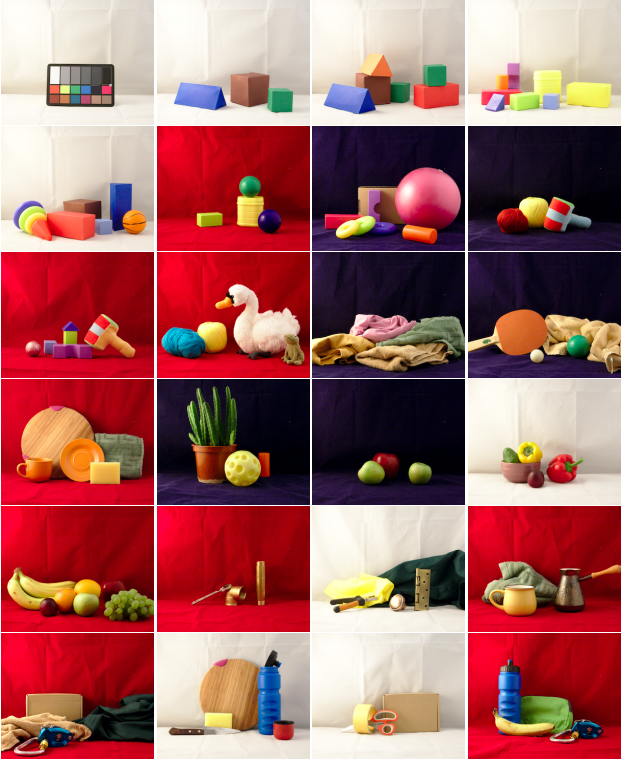

## Method
Take each of the 24x18 preview images, carry out 5 crops (4 corners + center) then pass to ResNet for classification. Record the classification. Compare classifications for for the same scene-crop pair for the 18 different illuminations. I am interested to see if the network classifications are invariant to illumination. The degree of illumination dependency for a scene-crop is measured by tallying the 18 classifications and calculating the entropy for this histogram/distribution. A low entropy means there is low diversity in classifications, and low diversity is what I intent to represent the idea that classification has low dependency on illumination. There are multiple ways one can measure diversity; entropy seems fine for this situtaion. (Diversity measures is an interesting topic in itself; Tom Leinster's ideas on diversity are great, for example: https://arxiv.org/abs/2012.02113. I try to find any excuse at all to read something by Tom Leinster.)

The code below carries out this idea. The narrative picks up up again afterwards to discuss the (not very useful) results.

In [1]:
import tempfile
import zipfile
import urllib
import numpy as np
import torch
import pathlib
import torchvision as tv
import torchvision.datasets
import torchvision.models
import torchvision.transforms
import pandas as pd
from icecream import ic
import json
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
with open('./resources/imagenet-simple-labels.json') as f:
    labels = json.load(f)
    
def class_id_to_label(cid):
    assert int(cid) == cid
    cid = int(cid)
    return labels[cid]

In [3]:
import IPython
def imshow(img):
    """Show image. 
    
    Image is a HWC numpy array with values in the range 0-1."""
    img = img*255
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # cv2 imencode takes images in HWC dimension order.
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i) 
    
    
def imlist(images, labels=None, use_tabs=False):
    if md_export_mode:
        print("Skipping ipyplot image print for markdown export. The output"
              " produces HTML that either Jupyter Lab fails to export correctly,"
              " or Hugo fails to render correctly. Skipping for now.")
        return
    if use_tabs:
        ipyplot.plot_class_tabs(images, labels, max_imgs_per_tab=300)
    else:
        ipyplot.plot_images(images, labels)

In [4]:
# Choose CPU or GPU.
device = torch.device('cuda:0')
#device = "cpu"

# Choose small or large (standard) model variant
model_name = "resnet18"
#model_name = 'resnet50'
def model_fctn():
    if model_name == 'resnet18':
        return tv.models.resnet18(pretrained=True)
    elif model_name == 'resnet50':
        return tv.models.resnet50(pretrained=True)
model = model_fctn()
state = torch.hub.load_state_dict_from_url(tv.models.resnet.model_urls[model_name])
model.load_state_dict(state)
model = model.to(device)
model.eval()

IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 4
NUM_FC_CHANNELS = 512 if model_name == 'resnet18' else 2048

In [5]:
ds_path = pathlib.Path('resources/exp_2/mls_dataset')
def is_empty(path):
    return not any(path.iterdir())
is_downloaded = ds_path.is_dir() and not is_empty(ds_path)
if not is_downloaded:
    ds_path.mkdir(exist_ok=True)
    zip_path, _ = urllib.request.urlretrieve('ftp://vis.iitp.ru/mls-dataset/images_preview.zip')
    with zipfile.ZipFile(zip_path, "r") as f:
        f.extractall(ds_path)

In [6]:
# Transforms
normalize_transform =  tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
crop = tv.transforms.FiveCrop(size=IMG_SHAPE[0])
pre_norm_transform = tv.transforms.Compose([crop])
norm_transform = tv.transforms.Compose([normalize_transform])

# Data details
num_scenes = 24
ignore_scenes = {1,} # 0: the Macbeth chart
scenes = [s for s in range(1, num_scenes+1) if s not in ignore_scenes]
crops = ['topleft', 'topright', 'bottomleft', 'bottomright', 'center']
illuminants = [
    '2HAL_DESK_LED-B025',
    '2HAL_DESK_LED-B050',
    '2HAL_DESK_LED-B075',
    '2HAL_DESK_LED-B100',
    '2HAL_DESK_LED-BG025',
    '2HAL_DESK_LED-BG050',
    '2HAL_DESK_LED-BG075',
    '2HAL_DESK_LED-BG100',
    '2HAL_DESK_R025',
    '2HAL_DESK_R050',
    '2HAL_DESK_R075',
    '2HAL_DESK_R100',
    '2HAL_DESK_RG025',
    '2HAL_DESK_RG050',
    '2HAL_DESK_RG075',
    '2HAL_DESK_RG100',
    '2HAL_DESK',
    '2HAL']


def img_key(scene_id, crop_label, illuminant):
    return f'{scene_id}-{crop_label}-{illuminant}'


def create_dataset():
    """
    Dataset as a dict. Keys are of the form: 04-topleft-2HAL_DESK_LED-B025.
    Images are 0-1 tensors.
    """
    images = dict()
    for s in scenes:
        for ill in illuminants:
            img_path = ds_path / 'images_preview' / f'{s:02d}' / f'{s:02d}_{ill}.jpg'
            # img is loaded as a [0-255] tensor with shape [3, 224, 224], so CHW.
            img = tv.io.read_image(str(img_path)) / 255.0
            cropped_images = pre_norm_transform(img)
            for label, ci in zip(crops, cropped_images):
                images[img_key(s, label, ill)] = ci
    return images

def entropy(x):
    x = x / x.sum()
    entr = -np.sum(x*np.log2(x))
    return entr
diversity_measure = entropy

In [7]:
def test_model():
    """
    (scene, illuminant, crop): label, pred, pred_val
    """
    ds = create_dataset()
    diversity_data = dict()
    cell_size = 2
    raw_data = np.zeros((len(scenes), len(crops), len(illuminants), cell_size))
    classification_val_id_pairs = []
    for s_idx, s in enumerate(scenes): 
        for crop_idx, crop in enumerate(crops):
            classification_ids = []
            for ill_idx, ill in enumerate(illuminants):
                img = ds[img_key(s, crop, ill)]
                input_ = torch.unsqueeze(normalize_transform(img), 0).to(device)
                model_out = model.forward(input_)
                #class_id = torch.argmax(model_out, dim=1)
                mval, class_id = torch.max(model_out, dim=1)
                classification_val_id_pairs.append((float(mval.cpu()), int(class_id)))
                #print(f'Max activation: {float(mval.cpu()):.3f},  \tclass label: {class_id_to_label(class_id)}')
                classification_ids.append(class_id)
                raw_data[s_idx][crop_idx][ill_idx] = (class_id.cpu(), mval.cpu())
            _, unique_counts = np.unique(classification_ids, return_counts=True)
            diversity_data[f'{s}-{crop}'] = diversity_measure(unique_counts)
    xdata = xr.DataArray(raw_data, coords={'scene':scenes, 'crop':crops, 'illuminant':illuminants, 'data':['class_id', 'mval']})
                         #dims=['scene', 'crop', 'illuminant', 'class_id', 'mval'])
    return diversity_data, xdata, classification_val_id_pairs
plot_data, data, val_id_pairs = test_model()

Text(0, 0.5, 'Confidence (Max output activation of ResNet)')

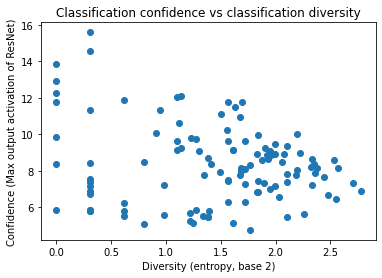

In [8]:
pd.set_option('display.max_rows', None)  
pd.Series(plot_data).to_frame()
#data.values.shape
fd = data.values.reshape((-1, 18, 2))
diversities = []
ave_scores = []
for sample in fd:
    _, unique_counts = np.unique(sample[:,0], return_counts=True)
    d = diversity_measure(unique_counts)
    s = np.mean(sample[:,1])
    diversities.append(d)
    ave_scores.append(s)
plt.scatter(diversities, ave_scores)
plt.title('Classification confidence vs classification diversity')
plt.xlabel('Diversity (entropy, base 2)')
plt.ylabel('Confidence (Max output activation of ResNet)')

In [10]:
mean_diversity = np.array(diversities).mean()
mean_diversity

1.4324161209572426

This is really high entropy. Let's check out the actual classifications. We don't have ground truth, but looking at the original 24 images, we have an idea of what is possible. Below is printed out the classifications and the confidence scores (just the max activation of the output layer).

In [ ]:
print('Classification:\n(max activation, class label)')
for val, idx in val_id_pairs:
    print(f'{val:.3f},\t{class_id_to_label(idx)}')

Many of the classes are completely unrelated to the objects found in the scenes. A very few classifications might be relevant, such as "banana", "coffee cup", "water bottle", "orange", and "bell pepper". Interestingly, "bath towel" isn't a class that is identified, although I would have expected it. For reference, see a list of the [1000 ImageNet classes](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 



## Discussion
It's hard to draw any useful conclusions. Based on how the classifications seem unrelated to the objects present in the scene, I think it was a mistake to assume that the ImageNet 1000 classes would cover most of the objects in the dataset's scenes. The fact that the scenes don't really map to ImageNet classes means that the experiment is a bit useless.


## Next step
I'll follow up in the minor increment experiment 2.0.1 by choosing crops such that the resulting images do contain objects covered by the ImageNet class list.